<a href="https://colab.research.google.com/github/yuqiw4/ANLY601Project/blob/master/TMDB_Prediction_Stacking_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['tmdb-competition-additional-features', 'tmdb-release-dates-per-country', 'tmdb-box-office-prediction']


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
warnings.filterwarnings("ignore")

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

In [0]:
train = pd.read_csv("../input/tmdb-box-office-prediction/train.csv")
test = pd.read_csv("../input/tmdb-box-office-prediction/test.csv")

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [0]:
train.shape, test.shape

((3000, 23), (4398, 22))

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [0]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [0]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [0]:
test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

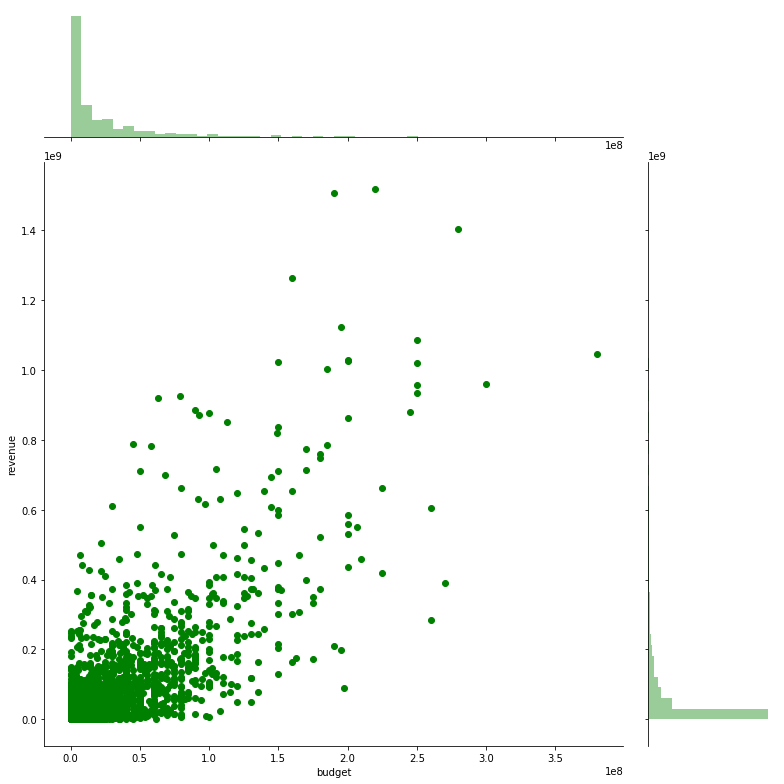

In [0]:
sns.jointplot(x="budget", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

In [0]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

In [0]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d
train = train
train['genres'] = train['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = train.genres.str.get_dummies(sep=',')
train = pd.concat([train, genres], axis=1, sort=False)
print("Action Genres Movie           ", train[train.Action == 1].shape[0])
print("Adventure Genres Movie        ", train[train.Adventure == 1].shape[0])
print("Animation Genres Movie        ", train[train.Animation == 1].shape[0])
print("Comedy Genres Movie           ", train[train.Comedy == 1].shape[0])
print("Crime Genres Movie            ", train[train.Crime == 1].shape[0])
print("Documentary Genres Movie      ", train[train.Documentary == 1].shape[0])
print("Drama Genres Movie            ", train[train.Drama == 1].shape[0])
print("Family Genres Movie           ", train[train.Family == 1].shape[0])
print("Fantasy Genres Movie          ", train[train.Fantasy == 1].shape[0])
print("Foreign Genres Movie          ", train[train.Foreign == 1].shape[0])
print("History Genres Movie          ", train[train.History == 1].shape[0])
print("Music Genres Movie            ", train[train.Music == 1].shape[0])
print("Mystery Genres Movie          ", train[train.Mystery == 1].shape[0])
print("Romance Genres Movie          ", train[train.Romance == 1].shape[0])
print("Science Fiction Genres Movie  ", train[train['Science Fiction'] == 1].shape[0])
print("TV Movie Genres Movie         ", train[train['TV Movie'] == 1].shape[0])
print("Thriller Genres Movie         ", train[train.Thriller == 1].shape[0])
print("War Genres Movie              ", train[train.War == 1].shape[0])
print("Western Genres Movie          ", train[train.Western == 1].shape[0])

Action Genres Movie            741
Adventure Genres Movie         439
Animation Genres Movie         141
Comedy Genres Movie            1028
Crime Genres Movie             469
Documentary Genres Movie       87
Drama Genres Movie             1531
Family Genres Movie            260
Fantasy Genres Movie           232
Foreign Genres Movie           31
History Genres Movie           132
Music Genres Movie             100
Mystery Genres Movie           225
Romance Genres Movie           571
Science Fiction Genres Movie   290
TV Movie Genres Movie          1
Thriller Genres Movie          789
War Genres Movie               100
Western Genres Movie           43


In [0]:
test = test
test['genres'] = test['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = test.genres.str.get_dummies(sep=',')
test = pd.concat([test, genres], axis=1, sort=False)
print("Action Genres Movie           ", test[test.Action == 1].shape[0])
print("Adventure Genres Movie        ", test[test.Adventure == 1].shape[0])
print("Animation Genres Movie        ", test[test.Animation == 1].shape[0])
print("Comedy Genres Movie           ", test[test.Comedy == 1].shape[0])
print("Crime Genres Movie            ", test[test.Crime == 1].shape[0])
print("Documentary Genres Movie      ", test[test.Documentary == 1].shape[0])
print("Drama Genres Movie            ", test[test.Drama == 1].shape[0])
print("Family Genres Movie           ", test[test.Family == 1].shape[0])
print("Fantasy Genres Movie          ", test[test.Fantasy == 1].shape[0])
print("Foreign Genres Movie          ", test[test.Foreign == 1].shape[0])
print("History Genres Movie          ", test[test.History == 1].shape[0])
print("Music Genres Movie            ", test[test.Music == 1].shape[0])
print("Mystery Genres Movie          ", test[test.Mystery == 1].shape[0])
print("Romance Genres Movie          ", test[test.Romance == 1].shape[0])
print("Science Fiction Genres Movie  ", test[test['Science Fiction'] == 1].shape[0])
print("TV Movie Genres Movie          0")
print("Thriller Genres Movie         ", test[test.Thriller == 1].shape[0])
print("War Genres Movie              ", test[test.War == 1].shape[0])
print("Western Genres Movie          ", test[test.Western == 1].shape[0])

Action Genres Movie            994
Adventure Genres Movie         677
Animation Genres Movie         241
Comedy Genres Movie            1577
Crime Genres Movie             615
Documentary Genres Movie       134
Drama Genres Movie             2145
Family Genres Movie            415
Fantasy Genres Movie           396
Foreign Genres Movie           53
History Genres Movie           163
Music Genres Movie             167
Mystery Genres Movie           325
Romance Genres Movie           864
Science Fiction Genres Movie   454
TV Movie Genres Movie          0
Thriller Genres Movie          1080
War Genres Movie               143
Western Genres Movie           74


In [0]:
train.loc[train['status'] == "Rumored"][['status','revenue']]

,status,revenue
609,Rumored,273644
1007,Rumored,60
1216,Rumored,13418091
1618,Rumored,229000


In [0]:
def prepare(df):
    global json_cols
    global train_dict

    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 18) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 18)  & (df['release_year'] < 100), "release_year"] += 1900
    
    rating_na = df.groupby(["release_year","original_language"])['rating'].mean().reset_index()
    df[df.rating.isna()]['rating'] = df.merge(rating_na, how = 'left' ,on = ["release_year","original_language"])
    
    vote_count_na = df.groupby(["release_year","original_language"])['totalVotes'].mean().reset_index()
    df[df.totalVotes.isna()]['totalVotes'] = df.merge(vote_count_na, how = 'left' ,on = ["release_year","original_language"])
    
    #budget_na = df.groupby(["release_year","original_language"])['budget'].mean().reset_index()
    #df.loc[df.budget == 0]['budget'] = df.merge(budget_na, how = 'left' ,on = ["release_year","original_language"])

    df['budget'] = np.log1p(df['budget'])
    
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter     

    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']


    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['_popularity_theatrical_ratio'] = df['theatrical']/df['popularity']
    df['_budget_theatrical_ratio'] = df['budget']/df['theatrical']
    #df['mean_theatrical_ByYear'] = df.groupby("release_year")["theatrical"].aggregate('mean')
    df['_popularity_totalVotes_ratio'] = df['totalVotes']/df['popularity']
    df['_totalVotes_releaseYear_ratio'] = df['totalVotes']/df['release_year']
    df['_budget_totalVotes_ratio'] = df['budget']/df['totalVotes']
    
    
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
    df['_rating_totalVotes_ratio'] = df['totalVotes']/df['rating']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    
    
    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # get collection id
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    
    

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id','movie_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True)

    return df
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')

#power_six = train.id[train.budget > 1000][train.revenue < 100]

#for k in power_six :
#    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000
#Clean Datapower_six 
 
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000





test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')

#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

In [0]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [0]:
release_dates = pd.read_csv('../input/tmdb-release-dates-per-country/release_dates_per_country.csv')
release_dates['id'] = range(1,7399)
release_dates.drop(['original_title','title'],axis = 1,inplace = True)
release_dates.index = release_dates['id']
train = pd.merge(train, release_dates, how='left', on=['id'])
test = pd.merge(test, release_dates, how='left', on=['id'])

In [0]:
trainAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('../input/tmdb-competition-additional-features/TestAdditionalFeatures.csv')

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])

In [0]:
test['revenue'] = np.nan

json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols + ['belongs_to_collection']) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))

print(train.shape)
train.head()


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


(3000, 69)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_year,movie_id,theatrical,theatrical_limited,IT,DE,FR,UA,LV,US,PT,CZ,SE,DK,KZ,NL,RU,HK,CL,TW,IE,NO,GR,GB,AU,CA,AR,BE,TR,FI,TH,IS,SK,IL,PL,ID,MX,AT,SI,HU,KW,BG,PE,popularity2,rating,totalVotes
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2015,243938,6.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.400,5.0,482.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,2004,11130,10.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.229,6.4,1528.0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,2014,244786,37.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.082,8.4,7314.0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2012,82825,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.531,7.5,115.0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred..

In [0]:
for col in train.columns: 
    print(col) 

id
belongs_to_collection
budget
genres
homepage
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
runtime
spoken_languages
status
tagline
title
Keywords
cast
crew
revenue
release_year
movie_id
theatrical
theatrical_limited
IT
DE
FR
UA
LV
US
PT
CZ
SE
DK
KZ
NL
RU
HK
CL
TW
IE
NO
GR
GB
AU
CA
AR
BE
TR
FI
TH
IS
SK
IL
PL
ID
MX
AT
SI
HU
KW
BG
PE
popularity2
rating
totalVotes


In [0]:
#train['revenue'] = np.log1p(train['revenue'])
#y_train = train['revenue'].values

#json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

#def get_dictionary(s):
#    try:
#        d = eval(s)
#    except:
#        d = {}
#    return d

#for col in tqdm(json_cols + ['belongs_to_collection']) :
#    train[col] = train[col].apply(lambda x : get_dictionary(x))
#    test[col] = test[col].apply(lambda x : get_dictionary(x))
    
def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)

# remove cateogry with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]
            

In [0]:
all_data = prepare(pd.concat([train, test]).reset_index(drop = True))
train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:] 

In [0]:
train.head()

,AR,AT,AU,BE,BG,CA,CL,CZ,DE,DK,FI,FR,GB,GR,HK,HU,ID,IE,IL,IS,IT,KW,KZ,LV,MX,NL,NO,PE,PL,PT,RU,SE,SI,SK,TH,TR,TW,UA,US,budget,...,Metro-Goldwyn-Mayer (MGM),Millennium Films,Miramax Films,Morgan Creek Productions,NPV Entertainment,New Line Cinema,New Regency Pictures,Original Film,Orion Pictures,Paramount Pictures,Participant Media,Phoenix Pictures,PolyGram Filmed Entertainment,Regency Enterprises,Relativity Media,Revolution Studios,Scott Free Productions,Scott Rudin Productions,Screen Gems,Silver Pictures,Spyglass Entertainment,Studio Babelsberg,StudioCanal,Summit Entertainment,TF1 Films Production,TSG Entertainment,The Weinstein Company,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Wild Bunch,Wildwood Enterprises,Working Title Films,production_companies_etc
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.454568,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.504390,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,15.009433,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.997833,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 242 entries, AR to production_companies_etc
dtypes: float64(69), int64(173)
memory usage: 5.5 MB


In [0]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

In [0]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

In [0]:
from catboost import CatBoostRegressor

def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
    
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation_0']['RMSE']}

In [0]:
features = list(train.columns)
features =  [i for i in features if i != 'id' and i != 'revenue']

In [0]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)})

    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))

In [0]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [0]:
Kfolder = KFoldValidation(train)

In [0]:
random_seed = 2019
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random_seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [0]:
Kfolder.validate(train, test, features , lgbmodel, name="lgbfinal", prepare_stacking=True) 

Fold  0 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.34131
[200]	valid_0's rmse: 2.16287
[300]	valid_0's rmse: 2.10424
[400]	valid_0's rmse: 2.07284
[500]	valid_0's rmse: 2.05759
[600]	valid_0's rmse: 2.04577
[700]	valid_0's rmse: 2.0365
[800]	valid_0's rmse: 2.03036
[900]	valid_0's rmse: 2.02673
[1000]	valid_0's rmse: 2.02445
[1100]	valid_0's rmse: 2.02244
[1200]	valid_0's rmse: 2.01964
[1300]	valid_0's rmse: 2.0185
[1400]	valid_0's rmse: 2.01718
[1500]	valid_0's rmse: 2.01682
[1600]	valid_0's rmse: 2.01583
[1700]	valid_0's rmse: 2.01799
[1800]	valid_0's rmse: 2.01785
[1900]	valid_0's rmse: 2.0169
[2000]	valid_0's rmse: 2.01749
Early stopping, best iteration is:
[1587]	valid_0's rmse: 2.01508
Fold  0  error:  2.0150827839668906
Fold  0  score:  2.0150827839668906
Fold  1 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.07055
[200]	valid_0's rmse: 1.88672
[300]	valid_0's rmse: 1.83105
[400]	valid_0's rm

1.8043016378742867

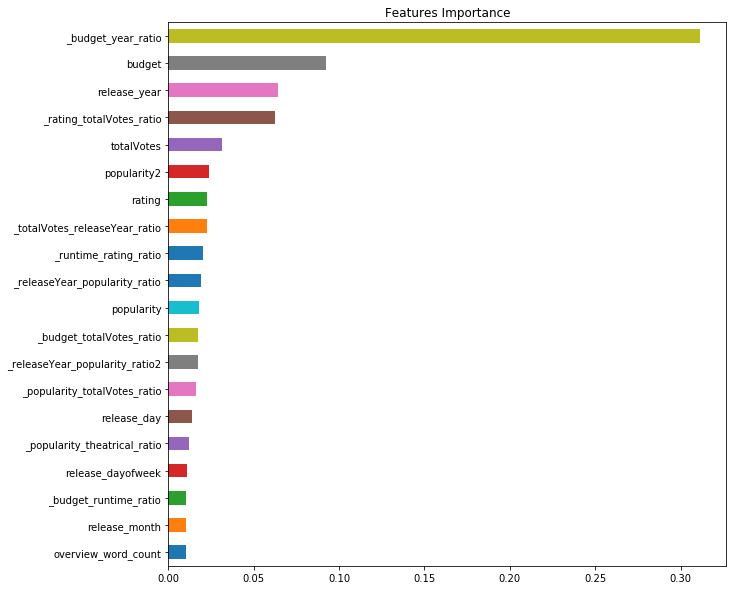

In [0]:
lgbmodel.FI.mean(axis=1).sort_values()[220:250].plot(kind="barh",title = "Features Importance", figsize = (10,10))

In [0]:
xgbmodel = xgb.XGBRegressor(max_depth=5, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=random_seed, 
                            silent=True,
                            subsample=0.8, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)


In [0]:
Kfolder.validate(train, test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:15.5563
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.03982
[200]	validation_0-rmse:2.96013
[300]	validation_0-rmse:2.23831
[400]	validation_0-rmse:2.11334
[500]	validation_0-rmse:2.08975
[600]	validation_0-rmse:2.07895
[700]	validation_0-rmse:2.0738
[800]	validation_0-rmse:2.06409
[900]	validation_0-rmse:2.05803
[1000]	validation_0-rmse:2.05419
[1100]	validation_0-rmse:2.05045
[1200]	validation_0-rmse:2.04744
[1300]	validation_0-rmse:2.04564
[1400]	validation_0-rmse:2.04534
[1500]	validation_0-rmse:2.04328
[1600]	validation_0-rmse:2.0427
[1700]	validation_0-rmse:2.04133
[1800]	validation_0-rmse:2.04018
[1900]	validation_0-rmse:2.03918
[2000]	validation_0-rmse:2.03724
[2100]	validation_0-rmse:2.03756
[2200]	validation_0-rmse:2.03754
[2300]	validation_0-rmse:2.03738
[2400]	validation_0-rmse:2.03646
[2500]	validation_0-rmse:2.03556
[2600]	validation_0-rmse:2.0352
[2700]	validation_0-rmse:2.03515
[2800]	validati

1.8230593209416943

In [0]:
catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=random_seed)

In [0]:
Kfolder.validate(train, test, features , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 16.1160435	test: 16.0425351	best: 16.0425351 (0)	total: 64.6ms	remaining: 10m 45s
100:	learn: 6.3975231	test: 6.3638894	best: 6.3638894 (100)	total: 1.23s	remaining: 2m
200:	learn: 3.1379487	test: 3.1960818	best: 3.1960818 (200)	total: 2.52s	remaining: 2m 3s
300:	learn: 2.2729169	test: 2.4304912	best: 2.4304912 (300)	total: 3.91s	remaining: 2m 6s
400:	learn: 2.0543183	test: 2.2765286	best: 2.2765286 (400)	total: 5.33s	remaining: 2m 7s
500:	learn: 1.9612019	test: 2.2284813	best: 2.2284813 (500)	total: 6.81s	remaining: 2m 9s
600:	learn: 1.8816361	test: 2.1950051	best: 2.1947687 (599)	total: 8.31s	remaining: 2m 10s
700:	learn: 1.8072257	test: 2.1740854	best: 2.1740854 (700)	total: 9.76s	remaining: 2m 9s
800:	learn: 1.7485463	test: 2.1536428	best: 2.1536428 (800)	total: 11.2s	remaining: 2m 8s
900:	learn: 1.6982308	test: 2.1356333	best: 2.1356333 (900)	total: 12.7s	remaining: 2m 8s
1000:	learn: 1.6555953	test: 2.1217385	best: 2.1216168 (997)	total: 14.2s	remaining: 2m 7s

2000:	learn: 1.6619832	test: 1.6798175	best: 1.6798162 (1999)	total: 30.4s	remaining: 2m 1s
2100:	learn: 1.6583696	test: 1.6777819	best: 1.6777345 (2085)	total: 31.9s	remaining: 1m 59s
2200:	learn: 1.6521481	test: 1.6733530	best: 1.6733530 (2200)	total: 33.4s	remaining: 1m 58s
2300:	learn: 1.6474959	test: 1.6707511	best: 1.6707292 (2290)	total: 34.9s	remaining: 1m 56s
2400:	learn: 1.6415572	test: 1.6679194	best: 1.6679194 (2400)	total: 36.4s	remaining: 1m 55s
2500:	learn: 1.6361790	test: 1.6654464	best: 1.6654464 (2500)	total: 37.9s	remaining: 1m 53s
2600:	learn: 1.6287523	test: 1.6616482	best: 1.6616431 (2595)	total: 39.5s	remaining: 1m 52s
2700:	learn: 1.6194039	test: 1.6573886	best: 1.6573790 (2699)	total: 41s	remaining: 1m 50s
2800:	learn: 1.6132079	test: 1.6545890	best: 1.6545890 (2800)	total: 42.6s	remaining: 1m 49s
2900:	learn: 1.6058066	test: 1.6522630	best: 1.6522521 (2899)	total: 44.1s	remaining: 1m 47s
3000:	learn: 1.6035844	test: 1.6514507	best: 1.6514507 (3000)	total: 45.7

4300:	learn: 1.3450023	test: 1.5810503	best: 1.5798501 (4161)	total: 1m 2s	remaining: 1m 22s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.579850056
bestIteration = 4161

Shrink model to first 4162 iterations.
Fold  3  error:  1.5798500507286626
Fold  3  score:  1.5798500507286626
Fold  4 :
0:	learn: 16.0960836	test: 16.1295017	best: 16.1295017 (0)	total: 13.9ms	remaining: 2m 19s
100:	learn: 6.4008701	test: 6.4954327	best: 6.4954327 (100)	total: 1.45s	remaining: 2m 21s
200:	learn: 3.1328021	test: 3.3168642	best: 3.3168642 (200)	total: 2.89s	remaining: 2m 21s
300:	learn: 2.2704437	test: 2.5150302	best: 2.5150302 (300)	total: 4.36s	remaining: 2m 20s
400:	learn: 2.0657372	test: 2.3285696	best: 2.3285696 (400)	total: 5.83s	remaining: 2m 19s
500:	learn: 1.9738429	test: 2.2536475	best: 2.2536475 (500)	total: 7.29s	remaining: 2m 18s
600:	learn: 1.9034851	test: 2.1959084	best: 2.1959084 (600)	total: 8.75s	remaining: 2m 16s
700:	learn: 1.8383375	test: 2.1544779	best: 2.15

1.7958115074044754

In [0]:
train['Revenue_lgb'] = train["lgbfinal"]

print("RMSE model lgb :" ,score(train, train.Revenue_lgb),)

train['Revenue_xgb'] = train["xgbfinal"]

print("RMSE model xgb :" ,score(train, train.Revenue_xgb))

train['Revenue_cat'] = train["catfinal"]

print("RMSE model cat :" ,score(train, train.Revenue_cat))

train['Revenue_Stacking1'] = 0.4 * train["lgbfinal"] + \
                               0.2 * train["xgbfinal"] + \
                               0.4 * train["catfinal"]

print("RMSE model Stacking1 :" ,score(train, train.Revenue_Stacking1))

train['Revenue_Stacking2'] = 0.35 * train["lgbfinal"] + \
                               0.3 * train["xgbfinal"] + \
                               0.35 * train["catfinal"]

print("RMSE model Stacking2 :" ,score(train, train.Revenue_Stacking2))



RMSE model lgb : 1.8118718998465193
RMSE model xgb : 1.8299003836984105
RMSE model cat : 1.8069055156498164
RMSE model Stacking1 : 1.7888354950502747
RMSE model Stacking2 : 1.791306961308064


In [0]:
train['Revenue_Stacking3'] = 0.5 * train["lgbfinal"] + \
                               0.1 * train["xgbfinal"] + \
                               0.4 * train["catfinal"]

print("RMSE model Stacking3 :" ,score(train, train.Revenue_Stacking3))

RMSE model Stacking3 : 1.7878665884450045


In [0]:
train['Revenue_Stacking4'] = 0.4 * train["lgbfinal"] + \
                               0.1 * train["xgbfinal"] + \
                               0.5 * train["catfinal"]

print("RMSE model Stacking4 :" ,score(train, train.Revenue_Stacking4))

RMSE model Stacking4 : 1.7868761292402653


In [0]:
test['revenue'] =  np.expm1(test["lgbfinal"])
test[['id','revenue']].to_csv('submission_lgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.632200e+07
3001,3002,4.243171e+05
3002,3003,7.343822e+06
3003,3004,4.273242e+06
3004,3005,9.874134e+05


In [0]:
test['revenue'] =  np.expm1(test["xgbfinal"])
test[['id','revenue']].to_csv('submission_xgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.869859e+07
3001,3002,6.109772e+05
3002,3003,7.494406e+06
3003,3004,4.182316e+06
3004,3005,8.241955e+05


In [0]:
test['revenue'] =  np.expm1(test["catfinal"])
test[['id','revenue']].to_csv('submission_cat.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,4.280745e+06
3001,3002,1.117818e+06
3002,3003,4.409157e+06
3003,3004,8.505548e+06
3004,3005,8.436468e+05


In [0]:
test['revenue'] =  np.expm1(0.4 * test["lgbfinal"]+ 0.4 * test["catfinal"] + 0.2 * test["xgbfinal"])
test[['id','revenue']].to_csv('submission_Stacking1.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,9.819264e+06
3001,3002,6.724033e+05
3002,3003,6.012548e+06
3003,3004,5.603602e+06
3004,3005,8.942726e+05


In [0]:
test['revenue'] =  np.expm1((test["lgbfinal"] + test["catfinal"] + test["xgbfinal"])/3)
test[['id','revenue']].to_csv('submission_Stacking2.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.093202e+07
3001,3002,6.617526e+05
3002,3003,6.237420e+06
3003,3004,5.336939e+06
3004,3005,8.821924e+05


In [0]:
test['revenue'] =  np.expm1(0.4 * test["lgbfinal"]+ 0.1 * test["catfinal"] + 0.5 * test["xgbfinal"])
test[['id','revenue']].to_csv('submission_Stacking3.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.528149e+07
3001,3002,5.609523e+05
3002,3003,7.049739e+06
3003,3004,4.528785e+06
3004,3005,8.880364e+05


In [0]:
test['revenue'] =  np.expm1(0.4 * test["lgbfinal"]+ 0.1 * test["catfinal"] + 0.5 * test["xgbfinal"])
test[['id','revenue']].to_csv('submission_Stacking1.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.528149e+07
3001,3002,5.609523e+05
3002,3003,7.049739e+06
3003,3004,4.528785e+06
3004,3005,8.880364e+05


In [0]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
#df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(test[['id','revenue']])

In [0]:
for col in train.columns:
    print(col)

AR
AT
AU
BE
BG
CA
CL
CZ
DE
DK
FI
FR
GB
GR
HK
HU
ID
IE
IL
IS
IT
KW
KZ
LV
MX
NL
NO
PE
PL
PT
RU
SE
SI
SK
TH
TR
TW
UA
US
budget
id
popularity
popularity2
rating
release_year
revenue
theatrical
theatrical_limited
totalVotes
release_month
release_day
genders_0_crew
genders_1_crew
genders_2_crew
_collection_name
_num_Keywords
_num_cast
release_dayofweek
release_quarter
_budget_runtime_ratio
_budget_popularity_ratio
_budget_year_ratio
_releaseYear_popularity_ratio
_releaseYear_popularity_ratio2
meanruntimeByYear
meanPopularityByYear
meanBudgetByYear
_popularity_theatrical_ratio
_budget_theatrical_ratio
_popularity_totalVotes_ratio
_totalVotes_releaseYear_ratio
_budget_totalVotes_ratio
_rating_popularity_ratio
_rating_totalVotes_ratio
_budget_rating_ratio
_runtime_rating_ratio
has_homepage
isbelongs_to_collectionNA
isTaglineNA
isOriginalLanguageEng
isTitleDifferent
isMovieReleased
original_title_letter_count
original_title_word_count
title_word_count
overview_word_count
tagline_word_count
produ